In [1]:
from PIL import Image, ImageFont, ImageDraw
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from rembg import remove
from transformers import OwlViTProcessor, OwlViTForObjectDetection, AutoProcessor
import itertools
import seaborn as sns
import brambox as bb
from typing import List, Tuple, Union, Optional, Dict
import time
import warnings
import sys

PyGEOS is not installed and thus segmentation related functionality will not work


In [2]:
# settings
annotations_folder_path: str = "../../../Data/Annotations/"
images_folder_path: str = "../../../Data/JPEGImages/"
fixed_images_path: str = "../../../Data/Fixed_support/"

examples_path: str = "../../../Tex/fig/chapter3/shell_examples/"
owlvit_outputs_path: str = "../../../Tex/fig/chapter3/owl-vit/outputs/"

# Defining some classes and values

In [3]:
class BBAnnotatedImage:
    def __init__(self, *, img_dir = "", filename= "", annotations:pd.DataFrame) -> None:
        if not filename:
            raise ValueError("filename cannot be empty")
        if not os.path.exists(os.path.join(img_dir, filename)):
            raise FileNotFoundError(f"image file {filename} not found in {img_dir}")
        self.filename: str = filename
        self.image: Image.Image = Image.open(os.path.join(img_dir, filename))
        self.annotations: pd.DataFrame = annotations
    
    @property
    def width(self) -> int:
        return self.image.width
    
    @property
    def height(self) -> int:
        return self.image.height
    
    @staticmethod
    def from_xml(xml_file:str, img_dir:str = "") -> 'BBAnnotatedImage':
        annotations:pd.DataFrame = bb.io.load('anno_pascalvoc', xml_file)
        filename = annotations.iloc[[0]]['image'].values[0] + '.jpg'
        return BBAnnotatedImage(filename = filename, img_dir = img_dir, annotations = annotations)
    
    def get_object_image_cutout(self, annotation_row:pd.Series) -> Image.Image:
        return self.image.crop((annotation_row['x_top_left'], annotation_row['y_top_left'], annotation_row['x_top_left'] + annotation_row['width'], annotation_row['y_top_left'] + annotation_row['height']))
    
    @property
    def annotation_classes(self) -> list[str]:
        return self.annotations['class_label'].tolist()
    
    @property
    def object_image_cutouts(self) -> list[Image.Image]:
        return [self.get_object_image_cutout(annotation) for _, annotation in self.annotations.iterrows()]
    
    @property
    def objects(self) -> list[tuple[str, Image.Image]]:
        return list(zip(self.annotation_classes, self.object_image_cutouts))

 
USE_TEXT = 0
USE_RANDOM_IMAGE = 1
USE_PICKED_IMAGE = 2

# loading the dataset

In [4]:
dir, dirs, files = next(os.walk(annotations_folder_path))

annotated_images:list[BBAnnotatedImage] = []

for file in files:
    annotated_images.append(BBAnnotatedImage.from_xml(annotations_folder_path + file, images_folder_path))

# add area column
for annotated_image in annotated_images:
    for _, annotation in annotated_image.annotations.iterrows():
        annotated_image.annotations.loc[_, 'area'] = annotation['width'] * annotation['height']

all_annotations = pd.concat([annotated_image.annotations for annotated_image in annotated_images])

print(all_annotations.head())


               image         class_label  id  x_top_left  y_top_left  width  \
0  IMG20230217102744       Baltic tellin NaN      2708.0      2272.0  300.0   
1  IMG20230217102744              Cockle NaN      3825.0      2803.0  295.0   
2  IMG20230217102744  Thick trough shell NaN      5850.0      4447.0  182.0   
0  IMG20230217102746       Baltic tellin NaN      2375.0      1783.0  445.0   
1  IMG20230217102746              Cockle NaN      4056.0      2530.0  445.0   

   height  occluded  truncated   lost  difficult  ignore      area  
0   258.0       0.0        0.0  False      False   False   77400.0  
1   253.0       0.0        0.0  False      False   False   74635.0  
2   172.0       0.0        0.0  False      False   False   31304.0  
0   392.0       0.0        0.0  False      False   False  174440.0  
1   397.0       0.0        0.0  False      False   False  176665.0  


In [6]:
# get list of all area values
area_values = []
for _, annotation in all_annotations.iterrows():
    area_values.append(annotation['area'])


print(max(area_values), min(area_values))
mean_area = np.mean(area_values)
std_area = np.std(area_values)
threshold_z_score = 2

areas_outlier_removed = []
for area in area_values:
    if abs(area - mean_area) < threshold_z_score * std_area:
        areas_outlier_removed.append(area)
print(max(areas_outlier_removed), min(areas_outlier_removed))

area_filter_treshold = max(areas_outlier_removed)
print(f"area filter threshold: {area_filter_treshold}")

5023460.0 27872.0
983740.0 27872.0
area filter threshold: 983740.0
time taken: 0.02073383331298828 seconds


## Dataset statistics

annotations: {
    "Baltic tellin": 69,
    "Cockle": 89,
    "Thick trough shell": 91,
    "Mussel": 268,
    "Banded wedge shell": 32,
    "Elliptical trough shell": 18,
    "Cut trough shell": 36,
    "Oyster": 9,
    "Jackknife": 2
}
Total images: 96
Total annotations: 614
Total images: 302
Total un-annotated images: 206
[27872.0, 30444.0, 31304.0, 34320.0, 35175.0, 35905.0, 38804.0, 39130.0, 39501.0, 39775.0, 40600.0, 41925.0, 43240.0, 43780.0, 45024.0, 45264.0, 45901.0, 46315.0, 46795.0, 50232.0, 54516.0, 55000.0, 56430.0, 56964.0, 57566.0, 59598.0, 60753.0, 62244.0, 63832.0, 63948.0, 64965.0, 66389.0, 67797.0, 67800.0, 67854.0, 68272.0, 69560.0, 69936.0, 70272.0, 71441.0, 72452.0, 72772.0, 74635.0, 74740.0, 75472.0, 77400.0, 77720.0, 77843.0, 77910.0, 78030.0, 78108.0, 78616.0, 78765.0, 78948.0, 79460.0, 79534.0, 80073.0, 80586.0, 82650.0, 82663.0, 84280.0, 84364.0, 86460.0, 86584.0, 87579.0, 87750.0, 87912.0, 89040.0, 89376.0, 93532.0, 94428.0, 94752.0, 95718.0, 96280.0, 96570.

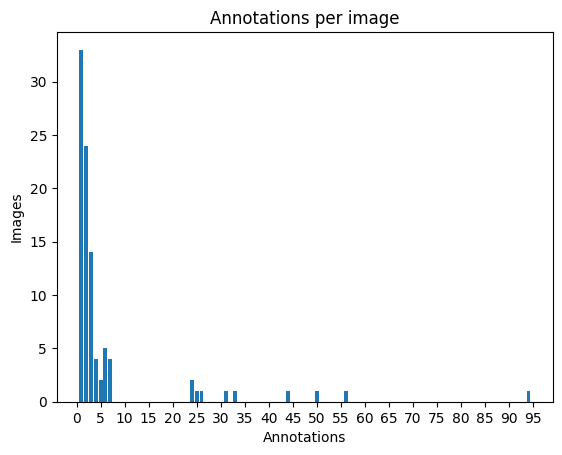

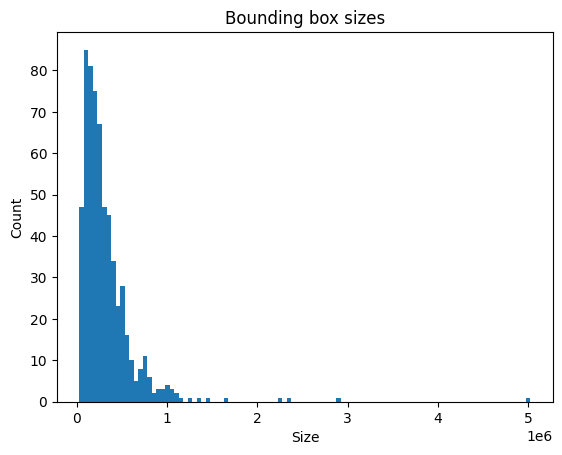

In [106]:
classes_count: dict[str, int] = {}

for _, annotation in all_annotations.iterrows():
    if annotation['class_label'] in classes_count:
        classes_count[annotation['class_label']] += 1
    else:
        classes_count[annotation['class_label']] = 1

print("annotations:", json.dumps(classes_count, indent=4))

print(f"Total images: {len(annotated_images)}")
print(f"Total annotations: {sum(classes_count.values())}")

# find the total un-anotated images
dir, dirs, files = next(os.walk(images_folder_path))
print(f"Total images: {len(files)}")
print(f"Total un-annotated images: {len(files) - len(annotated_images)}")

annotations_per_image_count = {}
for img in annotated_images:
    if len(img.annotations) in annotations_per_image_count:
        annotations_per_image_count[len(img.annotations)] += 1
    else:
        annotations_per_image_count[len(img.annotations)] = 1
# sort the dictionary by key
annotations_per_image_count = dict(sorted(annotations_per_image_count.items()))

# draw a graph of the annotations per image with as title "Annotations per image"
plt.bar(annotations_per_image_count.keys(), annotations_per_image_count.values())
plt.title("Annotations per image")
#more lines on the x-axis
plt.xticks(np.arange(0, max(annotations_per_image_count.keys()) + 5, 5.0))
plt.xlabel("Annotations")
plt.ylabel("Images")

# draw a bell curve of the size of the bounding boxes
# first get the sizes of the bounding boxes
sizes = []
for img in annotated_images:
    for _, annotation in img.annotations.iterrows():
        sizes.append(annotation['width'] * annotation['height'])
        
# sort the sizes
sizes.sort()
print(sizes)
# average and median size
print(f"Average size: {sum(sizes) / len(sizes)}")
print(f"Average compared to total image size: {((sum(sizes) / len(sizes)) / (img.width * img.height))*100}%")
print(f"Median size: {sizes[len(sizes) // 2]}")
plt.figure()
plt.hist(sizes, bins=100)
plt.title("Bounding box sizes")
plt.xlabel("Size")
plt.ylabel("Count")


# write 9 examples of images with annotations to a file (1.jpg => 9.jpg)
img_indexes = [1,5,20,54,92,52,15,65,75]
for i in range(9):
    annotated_image = annotated_images[img_indexes[i]]
    img = annotated_image.image.copy()
    draw = ImageDraw.Draw(img)
    for _, annotation in annotated_image.annotations.iterrows():
        draw.rectangle(((annotation['x_top_left'], annotation['y_top_left']), (annotation['x_top_left'] + annotation['width'], annotation['y_top_left'] + annotation['height'])), outline="red", width=20)
        draw.text((annotation['x_top_left'], annotation['y_top_left']), annotation['class_label'], fill="red", font=ImageFont.truetype("arial.ttf", 150))
    draw.text((10, 10), annotated_image.filename, fill="red", font=ImageFont.truetype("arial.ttf", 150))
    # resize the image by 10 times
    img = img.resize((int(img.width / 10), int(img.height / 10)))
    img.save(examples_path + str(i + 1) + ".jpg")

## Preparing the model

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
processor:OwlViTProcessor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

Using GPU


## Data loading

In [45]:
# mode = USE_TEXT
mode = USE_RANDOM_IMAGE
# mode = USE_PICKED_IMAGE

remove_bg = False

#clone all img into test list
test_images = annotated_images.copy()

if mode == USE_TEXT:
    raise NotImplementedError("I should implement this")

elif mode == USE_RANDOM_IMAGE:
    # find an image for each class and extract it
    support_images = set()
    support_images_cutouts = {}
    for class_name in classes_count:
        for img in annotated_images:
            for _, annotation in img.annotations.iterrows():
                if annotation['class_label'] == class_name:
                    support_images.add(img)
                    support_images_cutouts[class_name] = img.image.crop((annotation['x_top_left'], annotation['y_top_left'], annotation['x_top_left'] + annotation['width'], annotation['y_top_left'] + annotation['height']))
                    break
            if class_name in support_images_cutouts:
                break

    for img in support_images:
        test_images.remove(img)

elif mode == USE_PICKED_IMAGE:
    support_images_cutouts = {}
    imgs = list(os.walk(fixed_images_path + "base"))[0][2]
    for img in imgs:
        print(f"loading {img}")
        shell_name = img.split(".")[0]
        image = Image.open(fixed_images_path + "base/" + img)
        support_images_cutouts[shell_name] = image

else:
    raise NotImplementedError("Mode not set")

test_image_annotations = pd.concat([img.annotations for img in test_images])
print(test_image_annotations)

                image         class_label  id  x_top_left  y_top_left  width  \
0   IMG20230217102746       Baltic tellin NaN      2375.0      1783.0  445.0   
1   IMG20230217102746              Cockle NaN      4056.0      2530.0  445.0   
2   IMG20230217102746  Thick trough shell NaN      7369.0      4989.0  285.0   
0   IMG20230217102752              Cockle NaN      3110.0      1987.0  640.0   
1   IMG20230217102752              Cockle NaN      5253.0      3383.0  403.0   
..                ...                 ...  ..         ...         ...    ...   
2   IMG20230217105122       Baltic tellin NaN      1453.0      1211.0  436.0   
3   IMG20230217105122       Baltic tellin NaN       988.0      1402.0  513.0   
4   IMG20230217105122       Baltic tellin NaN      1417.0      3974.0  340.0   
5   IMG20230217105122       Baltic tellin NaN      2145.0      4237.0  388.0   
6   IMG20230217105122       Baltic tellin NaN      2068.0      4565.0  262.0   

    height  occluded  truncated   lost 

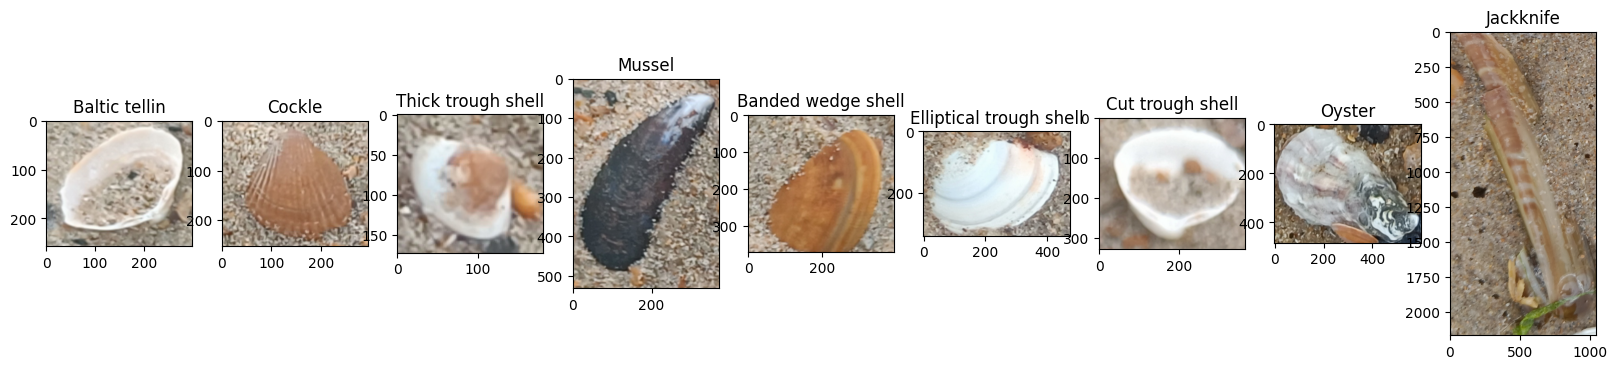

In [46]:
if remove_bg and (mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE):
    # loop over all support images and remove background
    for class_name, img in support_images_cutouts.items():
        print(f"removing background from {class_name}")
        img_copy = img.copy()
        img_copy = remove(img_copy, bgcolor=(0, 0, 0, 0)).convert("RGB")
        support_images_cutouts[class_name] = img_copy
        
if mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE:
    # show original images
    plt.figure(figsize=(20, 20))
    for i, (class_name, img) in enumerate(support_images_cutouts.items()):
        plt.subplot(1, len(support_images_cutouts), i + 1)
        plt.title(class_name)
        plt.imshow(img)
    if remove_bg:
        # show cutout images
        plt.figure(figsize=(20, 20))
        for i, (class_name, img) in enumerate(support_images_cutouts.items()):
            plt.subplot(1, len(support_images_cutouts), i + 1)
            plt.title(class_name)
            plt.imshow(img)
    

In [48]:
model = model.to(device)
model.eval()

outputs_list = []


vals = list(support_images_cutouts.values())

for q in range(len(test_images)):
    print(f"Query image {q}")

    test_image_annotated = test_images[q]

    test_image = test_image_annotated.image

    test_image_filename = test_image_annotated.filename

    inputs = processor(query_images=vals, images=test_image, return_tensors="pt").to(device)
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")
    
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()
    outputs.pred_boxes = outputs.target_pred_boxes.cpu()
    outputs_list.append(outputs)
    
# remove the model to free up memory
torch.cuda.empty_cache()


Query image 0
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 1
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 2
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 3
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 4
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 5
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 6
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 7
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 8
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 9
query_pixel_values: torch.Size([

In [49]:
# process and save the results for each query image for a set of score_thresholds with results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
score_thresholds: list[float] = [0.00] # can threshold afterwards

iou_thresholds: list[float] = [i / 20 for i in range(1, 21)]

In [50]:
# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

detections:pd.DataFrame = pd.DataFrame(columns=['image', 'class_label', 'id', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'iou_threshold'])


for q in range(len(test_images)):
# for q in range(1):
    image_results:pd.DataFrame = pd.DataFrame(columns=detections.columns)
    test_image_annotated = test_images[q]
    test_image_name = test_image_annotated.filename.split(".")[0]
    test_image = test_image_annotated.image
    target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))

    
    results = processor.post_process_object_detection(outputs=outputs_list[q], target_sizes=target_sizes, threshold=0.00)

    boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]
    for i in range(1, len(support_images_cutouts.keys())):
        im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
        boxes = torch.cat((boxes, im_boxes), dim=0)
        scores = torch.cat((scores, im_scores), dim=0)
        # add offset i to labels
        im_labels = im_labels + i
        labels = torch.cat((labels, im_labels), dim=0)

    boxes_orig = boxes
    scores_orig = scores
    labels_orig = labels

    for iou_threshold in iou_thresholds:
        threshold_results:pd.DataFrame = pd.DataFrame(columns=detections.columns)
        print(f"Query image {q}, iou_threshold {iou_threshold}:", end="")
        boxes = boxes_orig[:]
        scores = scores_orig[:]
        labels = labels_orig[:]

        indices = torchvision.ops.nms(boxes, scores, iou_threshold)
        boxes = boxes[indices]
        scores = scores[indices]
        labels = labels[indices]

        print(f" {len(boxes)} detections")
        for i in range(len(boxes)):
            box = boxes[i]
            score = scores[i]
            label = labels[i]
            class_label = list(support_images_cutouts.keys())[label]
            x_top_left, y_top_left, x_bottom_right, y_bottom_right = box
            x_top_left, y_top_left, x_bottom_right, y_bottom_right, score = x_top_left.item(), y_top_left.item(), x_bottom_right.item(), y_bottom_right.item(), score.item()
            width = x_bottom_right - x_top_left
            height = y_bottom_right - y_top_left
            new_row:pd.DataFrame = pd.DataFrame(columns=detections.columns, data=[[test_image_name, class_label, i, x_top_left, y_top_left, width, height, score, iou_threshold]])
            threshold_results = pd.concat([threshold_results, new_row], ignore_index=True)

        image_results = pd.concat([image_results, threshold_results], ignore_index=True)
    detections = pd.concat([detections, image_results], ignore_index=True)

# add area column
detections['image'] = detections['image'].astype('category')
detections['area'] = detections['width'] * detections['height']
bb.io.save(detections, "pandas",f"detections.pkl")


Query image 0, iou_threshold 0.05: 214 detections
Query image 0, iou_threshold 0.1: 243 detections
Query image 0, iou_threshold 0.15: 277 detections
Query image 0, iou_threshold 0.2: 300 detections
Query image 0, iou_threshold 0.25: 322 detections
Query image 0, iou_threshold 0.3: 342 detections
Query image 0, iou_threshold 0.35: 361 detections
Query image 0, iou_threshold 0.4: 389 detections
Query image 0, iou_threshold 0.45: 405 detections
Query image 0, iou_threshold 0.5: 433 detections
Query image 0, iou_threshold 0.55: 449 detections
Query image 0, iou_threshold 0.6: 479 detections
Query image 0, iou_threshold 0.65: 496 detections
Query image 0, iou_threshold 0.7: 512 detections
Query image 0, iou_threshold 0.75: 528 detections
Query image 0, iou_threshold 0.8: 545 detections
Query image 0, iou_threshold 0.85: 557 detections
Query image 0, iou_threshold 0.9: 564 detections
Query image 0, iou_threshold 0.95: 573 detections
Query image 0, iou_threshold 1.0: 5184 detections
Query ima

In [354]:
bb.io.save(detections, "pandas",f"detections_bck.pkl")

In [51]:
print(detections)

                     image              class_label    id   x_top_left  \
0        IMG20230217102746            Baltic tellin     0    10.840088   
1        IMG20230217102746  Elliptical trough shell     1  4210.152832   
2        IMG20230217102746            Baltic tellin     2   -30.347412   
3        IMG20230217102746            Baltic tellin     3  7241.875488   
4        IMG20230217102746  Elliptical trough shell     4  2331.572754   
...                    ...                      ...   ...          ...   
1171483  IMG20230217105122                Jackknife  5179  5530.361328   
1171484  IMG20230217105122                   Mussel  5180  5530.361328   
1171485  IMG20230217105122       Thick trough shell  5181  5530.361328   
1171486  IMG20230217105122       Banded wedge shell  5182  5530.361328   
1171487  IMG20230217105122         Cut trough shell  5183  5530.361328   

          y_top_left        width       height    confidence  iou_threshold  \
0          46.716614  8176.17944

In [94]:
detections:pd.DataFrame = bb.io.load("pandas", "detections.pkl")


print(len(detections))
print(detections)

1171488
                     image              class_label    id   x_top_left  \
0        IMG20230217102746            Baltic tellin     0    10.840088   
1        IMG20230217102746  Elliptical trough shell     1  4210.152832   
2        IMG20230217102746            Baltic tellin     2   -30.347412   
3        IMG20230217102746            Baltic tellin     3  7241.875488   
4        IMG20230217102746  Elliptical trough shell     4  2331.572754   
...                    ...                      ...   ...          ...   
1171483  IMG20230217105122                Jackknife  5179  5530.361328   
1171484  IMG20230217105122                   Mussel  5180  5530.361328   
1171485  IMG20230217105122       Thick trough shell  5181  5530.361328   
1171486  IMG20230217105122       Banded wedge shell  5182  5530.361328   
1171487  IMG20230217105122         Cut trough shell  5183  5530.361328   

          y_top_left        width       height    confidence  iou_threshold  \
0          46.716614  81

In [9]:
def get_detections_for_params(detections, *, area_filter_treshold_modifier=2, iou_threshold = None, score_threshold = None):
    # filter area smaller than area_filter_treshold * area_filter_treshold_modifier
    detections = detections[detections['area'] <= area_filter_treshold_modifier * area_filter_treshold]
    # detections = detections[detections['do_filtering'] == do_filtering]
    if iou_threshold is not None:
        detections = detections[detections['iou_threshold'] == iou_threshold]
    if score_threshold is not None:
        detections = detections[detections['confidence'] > score_threshold]
    return detections


In [10]:
def same_shell(df):
    df = df.copy()
    df['class_label'] = 'shell'
    return df


In [97]:
def get_detections_for_image(detections, image_name):
    detections_copy = detections.copy()
    return detections_copy[detections_copy['image'] == image_name]

def draw_boxes(image, image_name, detections, alligntop=True, draw_legend=True, line=True):
    img_copy = image.copy()
    detections = get_detections_for_image(detections, image_name)
    default_colors = [
        (31, 119, 180),
        (255, 127, 14),
        (44, 160, 44),
        (214, 39, 40),
        (148, 103, 189),
        (140, 86, 75),
        (227, 119, 194),
        (127, 127, 127),
        (188, 189, 34),
        (23, 190, 207),
    ]
    colors_assigned = dict(zip(all_annotations['class_label'].unique(), default_colors))
    # map all detections to colors inplace in detections
    detections['color'] = detections['class_label'].map(colors_assigned)

    if line:
        # make all colors darker
        detections['color'] = detections['color'].apply(lambda x: tuple([int(y * 0.9) for y in x]))
        boxed = bb.util.draw_boxes(img_copy, detections, size = 15)
    else:
        boxed = bb.util.draw_boxes(img_copy, detections, size = 0, fill=True, alpha=0.4)
    draw = ImageDraw.Draw(boxed)
    if draw_legend:
    # write legend in top left corner
        if alligntop:
            legend_x = 10
            legend_y = 10
            legend_size = 200
            for class_label, color in colors_assigned.items():
                draw.rectangle([legend_x, legend_y, legend_x + legend_size, legend_y + legend_size], fill=color)
                draw.text((legend_x + legend_size + 10, legend_y), class_label, fill=color, font=ImageFont.truetype("arial.ttf", legend_size))
                legend_y += legend_size + 10
        else:
            #legend in bottom left corner
            legend_x = 10
            legend_y = boxed.height - 10
            legend_size = 200
            for class_label, color in colors_assigned.items().__reversed__():
                draw.rectangle([legend_x, legend_y - legend_size, legend_x + legend_size, legend_y], fill=color)
                draw.text((legend_x + legend_size + 10, legend_y - legend_size), class_label, fill=color, font=ImageFont.truetype("arial.ttf", legend_size))
                legend_y -= legend_size + 10

    return boxed

In [74]:

img_indexes = [1,5,20,54,92,52,15,65,75]

for img_index in range(len(annotated_images)):
    image = annotated_images[img_index].filename.split(".")[0]


    filtered_detections = get_detections_for_params(detections, area_filter_treshold_modifier=1, iou_threshold=1, score_threshold=0.2)
    annotations_for_img = get_detections_for_image(all_annotations, image)

    detections_drawn = draw_boxes(annotated_images[img_index].image, image, filtered_detections, draw_legend=False)
    annotationsdrawn = draw_boxes(detections_drawn, image, annotations_for_img, line=False)

    annotationsdrawn.save(f"out/detections/{img_index}detections.jpg")



C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)
C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['color'].apply(lambda x: tuple([int(y * 0.9) for y in x]))
C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a 

In [53]:

area_filter_threshold_modifiers = [1, 2, 5, 10, 20, 50, 100]

categoryless_detections  = same_shell(detections)
categoryless_annotations = same_shell(test_image_annotations)



In [78]:


for img_index in range(len(annotated_images)):
    try:
        image = annotated_images[img_index].filename.split(".")[0]


        filtered_detections = get_detections_for_params(categoryless_detections, area_filter_treshold_modifier=1, score_threshold=0.5, iou_threshold=1)
        annotations_for_img = get_detections_for_image(categoryless_annotations, image)

        detections_drawn = draw_boxes(annotated_images[img_index].image, image, filtered_detections, draw_legend=False)
        annotationsdrawn = draw_boxes(detections_drawn, image, annotations_for_img, line=False)

        annotationsdrawn.save(f"out/cat_less_detections/{img_index}detections.jpg")
    except Exception as e:
        print(f"error on image {img_index}: {e}")



C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 1: 'float' object is not iterable
error on image 2: 'float' object is not subscriptable
error on image 3: 'float' object is not subscriptable
error on image 6: 'float' object is not subscriptable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 7: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 8: 'float' object is not iterable
error on image 9: 'float' object is not subscriptable
error on image 10: 'float' object is not subscriptable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 11: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 12: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 13: 'float' object is not iterable
error on image 14: 'float' object is not subscriptable
error on image 15: 'float' object is not subscriptable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 16: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 17: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 18: 'float' object is not iterable
error on image 19: 'float' object is not subscriptable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 20: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 21: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 22: 'float' object is not iterable


C:\Users\tijse\AppData\Local\Temp\ipykernel_41756\175423879.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections['color'] = detections['class_label'].map(colors_assigned)


error on image 23: 'float' object is not iterable


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for area_filter_treshold_mod in area_filter_threshold_modifiers:
    test = get_detections_for_params(categoryless_detections, area_filter_treshold_modifier=area_filter_treshold_mod, score_threshold=0.1, iou_threshold=1)
    print(len(test))
    
    pr = bb.stat.pr(test, categoryless_annotations, threshold=0.5, smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"area_filter_treshold_modifier={area_filter_treshold_mod}, AP={100 * ap:.2f}%")
    

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different do_filtering values")
plt.show()

### Find best parameters

best ap: 1.2860466522023142%, best fscore: 4.298874104401229%
maximize ap: nms=1.0, area_filter=1
maximize fscore: nms=1.0, area_filter=1


Text(0.5, 1.0, 'Precision-Recall curve for different nms values')

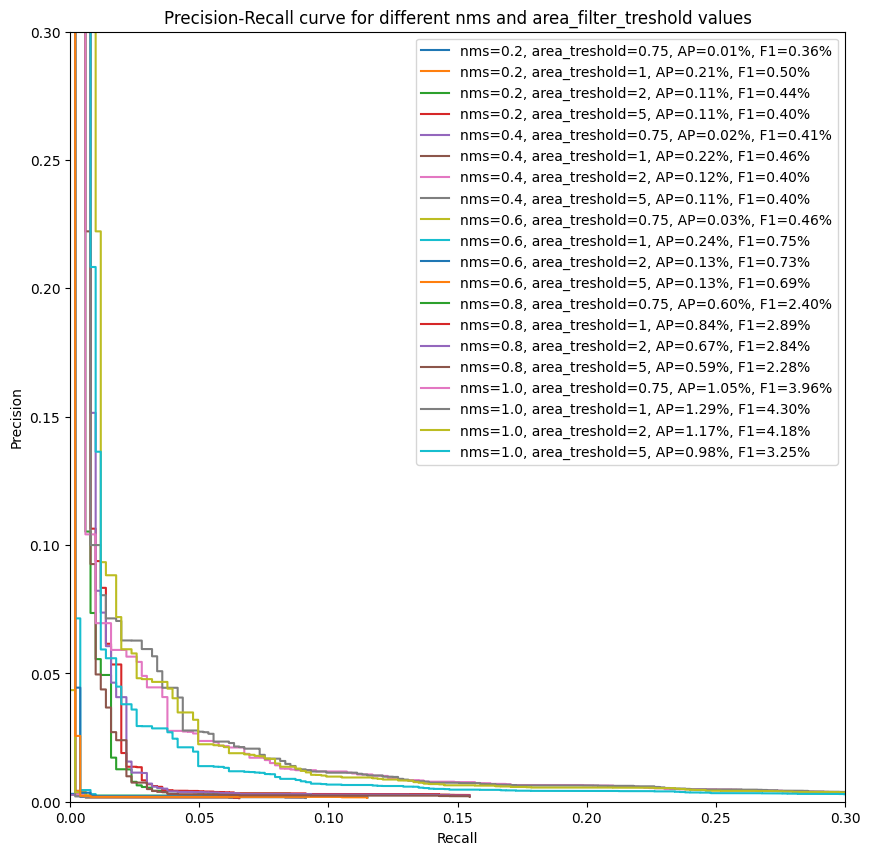

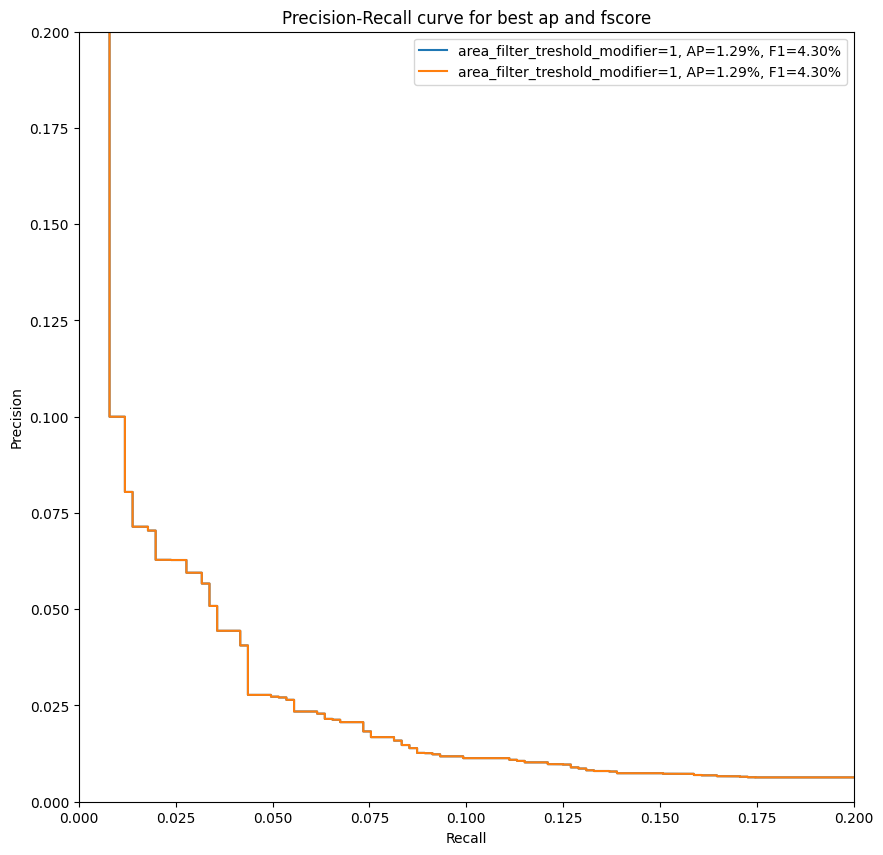

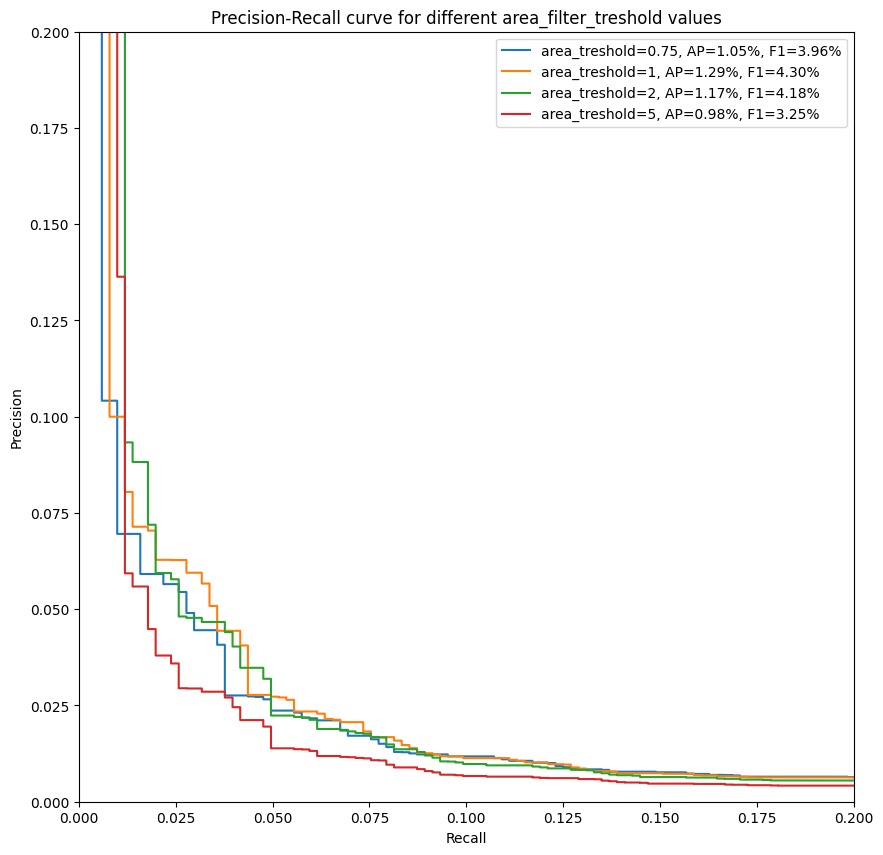

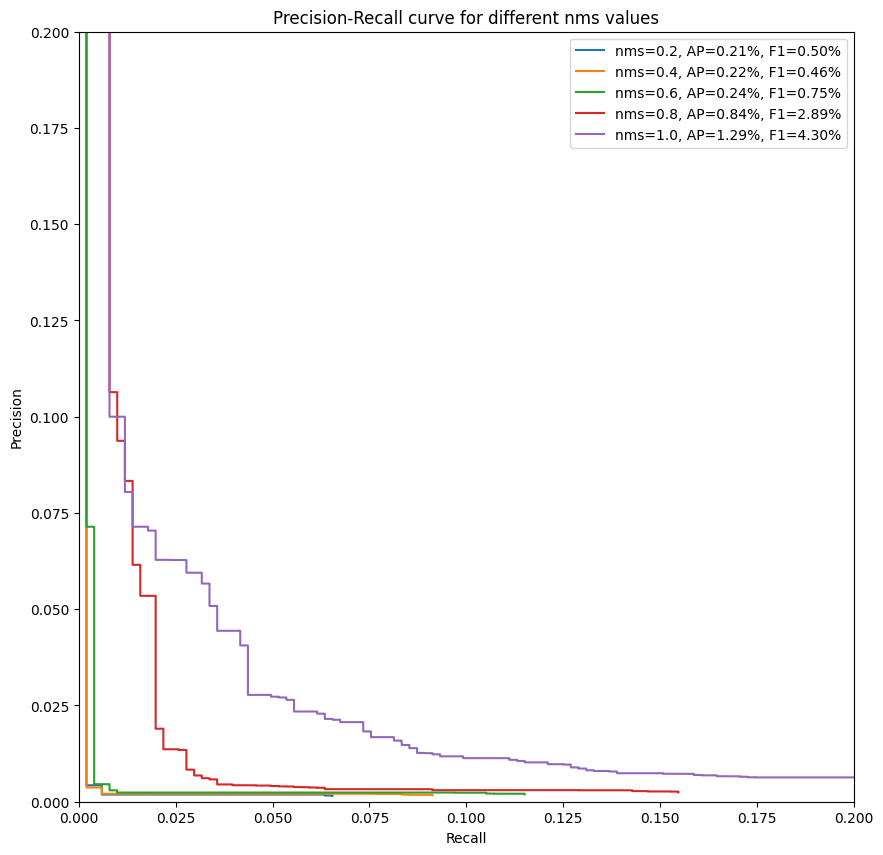

In [73]:

area_filter_threshold_modifiers = [0.75, 1, 2, 5]
nms_thresholds = detections['iou_threshold'].unique()
nms_thresholds = [i/5 for i in range(1,6)]

# remove jackknife
detections = detections[detections['class_label'] != 'Jackknife']
test_image_annotations = test_image_annotations[test_image_annotations['class_label'] != 'Jackknife']


max_ap = 0
max_ap_nms = 0
max_ap_area_filter = 0
max_ap_pr = None
max_ap_fscore = 0

max_fscore = None
max_fscore_f1 = 0
max_fscore_nms = 0
max_fscore_area_filter = 0
max_fscore_pr = None
max_fscore_ap = 0

fig, ax = plt.subplots(figsize=(10,10))

for nms_threshold in nms_thresholds:
    for area_filter_treshold_mod in area_filter_threshold_modifiers:
        test = get_detections_for_params(detections, area_filter_treshold_modifier=area_filter_treshold_mod, iou_threshold=nms_threshold)

        pr = bb.stat.pr(test, test_image_annotations, threshold=0.5, smooth=True)
        ap = bb.stat.ap(pr)
        fscore = bb.stat.fscore(pr)
        peakf1 = bb.stat.peak(fscore)
        ax.plot(pr['recall'], pr['precision'], label=f"nms={nms_threshold}, area_treshold={area_filter_treshold_mod}, AP={100 * ap:.2f}%, F1={100 * peakf1.f1:.2f}%")
        
        if ap > max_ap:
            max_ap = ap
            max_ap_nms = nms_threshold
            max_ap_area_filter = area_filter_treshold_mod
            max_ap_pr = pr
            max_ap_fscore = peakf1.f1
        if peakf1.f1 > max_fscore_f1:
            max_fscore_f1 = peakf1.f1
            max_fscore = peakf1
            max_fscore_nms = nms_threshold
            max_fscore_area_filter = area_filter_treshold_mod
            max_fscore_pr = pr
            max_fscore_ap = ap
            topf1 = bb.stat.point(pr, peakf1.f1)
plt.title("Precision-Recall curve for different nms and area_filter_treshold values")
ax.set_xlim(0,0.3)
ax.set_ylim(0,0.3)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

print(f"best ap: {max_ap * 100}%, best fscore: {max_fscore_f1 * 100}%")
print(f"maximize ap: nms={max_ap_nms}, area_filter={max_ap_area_filter}")
print(f"maximize fscore: nms={max_fscore_nms}, area_filter={max_fscore_area_filter}")

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(max_ap_pr['recall'], max_ap_pr['precision'], label=f"area_filter_treshold_modifier={max_ap_area_filter}, AP={100 * max_ap:.2f}%, F1={100 * max_ap_fscore:.2f}%")
ax.plot(max_fscore_pr['recall'], max_fscore_pr['precision'], label=f"area_filter_treshold_modifier={max_fscore_area_filter}, AP={100 * max_fscore_ap:.2f}%, F1={100 * max_fscore_f1:.2f}%")
ax.set_xlim(0,0.2)
ax.set_ylim(0,0.2)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for best ap and fscore")

fig, ax = plt.subplots(figsize=(10,10))

for area_filter_treshold_mod in area_filter_threshold_modifiers:
    test = get_detections_for_params(detections, area_filter_treshold_modifier=area_filter_treshold_mod, iou_threshold=1)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0.5, smooth=True)
    ap = bb.stat.ap(pr)
    fscore = bb.stat.fscore(pr)
    peakf1 = bb.stat.peak(fscore)
    ax.plot(pr['recall'], pr['precision'], label=f"area_treshold={area_filter_treshold_mod}, AP={100 * ap:.2f}%, F1={100 * peakf1.f1:.2f}%")
    
    if ap > max_ap:
        max_ap = ap
        max_ap_nms = nms_threshold
        max_ap_area_filter = area_filter_treshold_mod
        max_ap_pr = pr
        max_ap_fscore = peakf1.f1
    if peakf1.f1 > max_fscore_f1:
        max_fscore_f1 = peakf1.f1
        max_fscore = peakf1
        max_fscore_nms = nms_threshold
        max_fscore_area_filter = area_filter_treshold_mod
        max_fscore_pr = pr
        max_fscore_ap = ap
        topf1 = bb.stat.point(pr, peakf1.f1)

ax.set_xlim(0,0.2)
ax.set_ylim(0,0.2)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different area_filter_treshold values")

fig, ax = plt.subplots(figsize=(10,10))

for nms_threshold in nms_thresholds:
    test = get_detections_for_params(detections, area_filter_treshold_modifier=1, iou_threshold=nms_threshold)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0.5, smooth=True)
    ap = bb.stat.ap(pr)
    fscore = bb.stat.fscore(pr)
    peakf1 = bb.stat.peak(fscore)
    ax.plot(pr['recall'], pr['precision'], label=f"nms={nms_threshold}, AP={100 * ap:.2f}%, F1={100 * peakf1.f1:.2f}%")
    
    if ap > max_ap:
        max_ap = ap
        max_ap_nms = nms_threshold
        max_ap_area_filter = area_filter_treshold_mod
        max_ap_pr = pr
        max_ap_fscore = peakf1.f1
    if peakf1.f1 > max_fscore_f1:
        max_fscore_f1 = peakf1.f1
        max_fscore = peakf1
        max_fscore_nms = nms_threshold
        max_fscore_area_filter = area_filter_treshold_mod
        max_fscore_pr = pr
        max_fscore_ap = ap
        topf1 = bb.stat.point(pr, peakf1.f1)

ax.set_xlim(0,0.2)
ax.set_ylim(0,0.2)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different nms values")



In [105]:

# write 9 examples of images to a file (1.jpg => 9.jpg)
img_indexes = [1,5,20,54,92,52,15,65,75]

for i in range(len(img_indexes)):
    img_index = img_indexes[i]
    image = annotated_images[img_index].filename.split(".")[0]


    filtered_detections = get_detections_for_params(detections, area_filter_treshold_modifier=1, score_threshold=0.5, iou_threshold=1)
    annotations_for_img = get_detections_for_image(test_image_annotations, image)

    detections_drawn = draw_boxes(annotated_images[img_index].image, image, filtered_detections, draw_legend=False)
    annotationsdrawn = draw_boxes(detections_drawn, image, annotations_for_img, line=False)

    annotationsdrawn = annotationsdrawn.resize((int(annotationsdrawn.width /10), int(annotationsdrawn.height /10)))
    
    annotationsdrawn.save(f"{owlvit_outputs_path}{i+1}.jpg")

### Find best parameters without classes

best ap: 6.416179825227553%, best fscore: 13.974455296769344%
maximize ap: nms=0.95, area_filter=1
maximize fscore: nms=0.95, area_filter=0.75


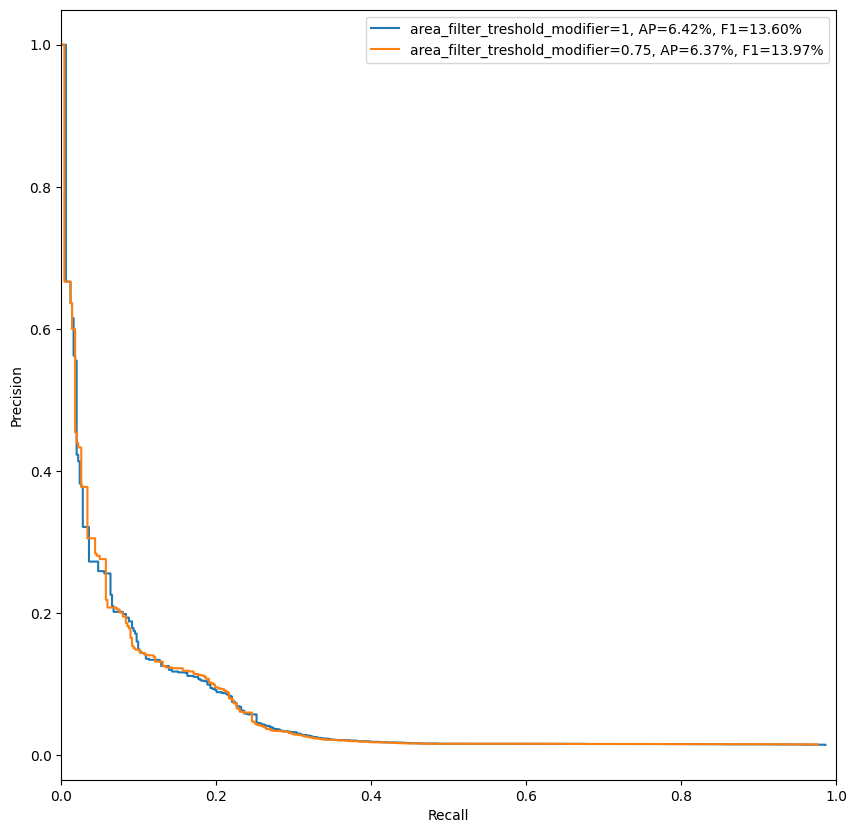

In [59]:

area_filter_threshold_modifiers = [0.75, 1, 2, 5]
nms_thresholds = detections['iou_threshold'].unique()


# remove jackknife
detections = detections[detections['class_label'] != 'Jackknife']
test_image_annotations = test_image_annotations[test_image_annotations['class_label'] != 'Jackknife']

# set all labels to 'Shell'
classless_detections = detections.copy()
classless_detections['class_label'] = 'Shell'
classless_annotations = test_image_annotations.copy()
classless_annotations['class_label'] = 'Shell'

max_ap = 0
max_ap_nms = 0
max_ap_area_filter = 0
max_ap_pr = None
max_ap_fscore = 0

max_fscore = None
max_fscore_f1 = 0
max_fscore_nms = 0
max_fscore_area_filter = 0
max_fscore_pr = None
max_fscore_ap = 0

for nms_threshold in nms_thresholds:
    for area_filter_treshold_mod in area_filter_threshold_modifiers:
        test = get_detections_for_params(classless_detections, area_filter_treshold_modifier=area_filter_treshold_mod, iou_threshold=nms_threshold)

        pr = bb.stat.pr(test, classless_annotations, threshold=0.3, smooth=True)
        ap = bb.stat.ap(pr)
        fscore = bb.stat.fscore(pr)
        peakf1 = bb.stat.peak(fscore)
        
        if ap > max_ap:
            max_ap = ap
            max_ap_nms = nms_threshold
            max_ap_area_filter = area_filter_treshold_mod
            max_ap_pr = pr
            max_ap_fscore = peakf1.f1
        if peakf1.f1 > max_fscore_f1:
            max_fscore_f1 = peakf1.f1
            max_fscore = peakf1
            max_fscore_nms = nms_threshold
            max_fscore_area_filter = area_filter_treshold_mod
            max_fscore_pr = pr
            max_fscore_ap = ap
            topf1 = bb.stat.point(pr, peakf1.f1)

print(f"best ap: {max_ap * 100}%, best fscore: {max_fscore_f1 * 100}%")
print(f"maximize ap: nms={max_ap_nms}, area_filter={max_ap_area_filter}")
print(f"maximize fscore: nms={max_fscore_nms}, area_filter={max_fscore_area_filter}")

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(max_ap_pr['recall'], max_ap_pr['precision'], label=f"area_filter_treshold_modifier={max_ap_area_filter}, AP={100 * max_ap:.2f}%, F1={100 * max_ap_fscore:.2f}%")
ax.plot(max_fscore_pr['recall'], max_fscore_pr['precision'], label=f"area_filter_treshold_modifier={max_fscore_area_filter}, AP={100 * max_fscore_ap:.2f}%, F1={100 * max_fscore_f1:.2f}%")
ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

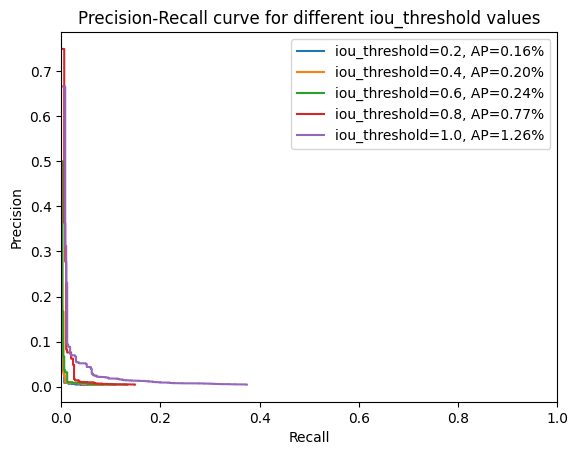

In [60]:

iou_threshold_values = detections['iou_threshold'].unique()
iou_threshold_values.sort()

fig, ax = plt.subplots()

for iou_threshold in iou_threshold_values:
    test = get_detections_for_params(detections, iou_threshold=iou_threshold)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0.1, smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"iou_threshold={iou_threshold}, AP={100 * ap:.2f}%")

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different iou_threshold values")
plt.show()


In [145]:
filtered = get_detections_for_params(detections, do_filtering=True)

bb.io.save(filtered, "pandas",f"filtered.csv")

Saving as csv does not retain categorical dtypes! You will thus lose all images that have no boxes.
